# ViT-based model using Transfer-Learning
---
#### Model: google/vit-large-patch16-224, descongelando las últimas 5 capas del encoder
#### Epochs: 10
#### Dataset: images_3categories_balanced

In [30]:
# Parámetros
_model = 'google/vit-large-patch16-224'
_checkpoint = 'SavedModels/ViT-large-patch16-224_B/checkpoint-3760'  # path al checkpoint a cargar
_output = 'SavedModels/ViT-large-patch16-224_B'  # path para guardar el modelo

_dataset = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_3categories_balanced'

# path para guardar el dataset con split
_dataset_split_path = '/Users/julio/Documentos-Local/data/VinDr-Mammo/subsets/images_3categories_balanced_split'  
# path al dataset ya separado en train, validation y test. None eoc
_dataset_split = None  

_batch_size = 16
_learning_rate = 3e-4
_epochs = 10

num_layers_to_unfreeze = 5  # Definir el número de capas a descongelar, None eoc

In [2]:
import torch

from datasets import load_dataset, DatasetDict, load_from_disk

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

from Utils import *

## Carga de datos

In [3]:
if _dataset_split is None:
    dataset = load_dataset(_dataset)
else:
    # Cargar el dataset previamente guardado
    dataset = load_from_disk(_dataset_split_path)

dataset

Resolving data files:   0%|          | 0/7504 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7504
    })
})

### Revisión de categorías

In [4]:
labels = dataset['train'].features['label'].names
print(len(labels),labels)

label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

3 ['calcificaciones', 'masas', 'no_encontrado']


## Muestra de ejemplos

In [5]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
            
# show_samples(dataset['train'],rows=3,cols=5)

## Split Dataset

In [6]:
if _dataset_split is None:
    split_dataset = dataset['train'].train_test_split(test_size=0.2)
    eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)
    
    
    # Recombinar los splits 
    
    final_dataset = DatasetDict({
        'train': split_dataset['train'],
        'validation': eval_dataset['train'],
        'test': eval_dataset['test']
    })
    # Guardar el dataset dividido
    final_dataset.save_to_disk(_dataset_split_path)

else:
    final_dataset = dataset
final_dataset

Saving the dataset (0/1 shards):   0%|          | 0/6003 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/750 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/751 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6003
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 751
    })
})

## Preprocesamiento de las imágenes

In [7]:
processor = AutoImageProcessor.from_pretrained(_model, use_fast=True)
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels'] = batch['label']  # Las clases ya están en formato numérico
    return inputs

In [9]:
processed_dataset = final_dataset.with_transform(transforms)

### Data Collation

In [10]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Métricas de evaluación

In [11]:
import numpy as np
import evaluate

accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    # Accuracy no requiere el parámetro average
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)['accuracy']
    
    # Las demás métricas sí requieren el parámetro average para multiclase
    precision_score = precision.compute(predictions=predictions, references=labels, average='macro')['precision']
    recall_score = recall.compute(predictions=predictions, references=labels, average='macro')['recall']
    f1_score = f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    
    return {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }

## Carga del modelo

In [12]:
model = ViTForImageClassification.from_pretrained(
    _model,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Arquitectura del modelo

In [13]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Lin

### Congelar todas las capas, menos el clasificador

In [14]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [15]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 303,304,707 | trainable_params = 3,075


### Descongelar capas del encoder para fine-tuning

In [16]:
# Obtener el número total de capas en el encoder
num_total_layers = len(list(model.vit.encoder.layer))  # Debería ser 24 para ViT-Large, 12 para ViT-base
print(num_total_layers)

24


In [17]:
# Si se descongelan capas
if num_layers_to_unfreeze is not None:
    # Calcular el índice a partir del cual descongelar
    unfreeze_from = num_total_layers - num_layers_to_unfreeze
    
    # Iterar sobre todas las capas del encoder
    for idx, layer in enumerate(model.vit.encoder.layer):
        if idx >= unfreeze_from:
            # Descongelar esta capa
            for param in layer.parameters():
                param.requires_grad = True
        else:
            # Congelar esta capa
            for param in layer.parameters():
                param.requires_grad = False


In [18]:
# Mostrar el número total de parámetros y los entrenables después de descongelar
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Después de descongelar las últimas {num_layers_to_unfreeze} capas:")
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Después de descongelar las últimas 5 capas:
Total de parámetros: 303,304,707
Parámetros entrenables: 62,984,195


In [19]:
# Revisión de trainable por capa
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    #print(f"{name}: {status}")

## Training

In [20]:
training_args = TrainingArguments(
    output_dir=_output,
    per_device_train_batch_size=_batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=_epochs,  # Epochs a entrenar -> Revisar
    learning_rate=_learning_rate,
    save_total_limit=3,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [22]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS enabled")

MPS enabled


In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.781800,0.745146,0.669333,0.666552,0.670834,0.667928
2,0.697500,0.737027,0.652000,0.659859,0.651917,0.652745
3,0.593400,0.690168,0.682667,0.680883,0.683454,0.671642
4,0.494300,0.750647,0.680000,0.672759,0.682389,0.660704
5,0.362500,0.900683,0.669333,0.665503,0.671707,0.658345
6,0.271700,1.033396,0.658667,0.665298,0.658994,0.661443
7,0.188000,1.364662,0.648000,0.647431,0.648826,0.648060
8,0.096600,1.712113,0.650667,0.651803,0.651979,0.651062
9,0.049200,2.092435,0.664000,0.662449,0.664856,0.663472
10,0.019800,2.349191,0.673333,0.669780,0.674269,0.671461


TrainOutput(global_step=3760, training_loss=0.3633806535855253, metrics={'train_runtime': 4045.0405, 'train_samples_per_second': 14.84, 'train_steps_per_second': 0.93, 'total_flos': 1.6444324389874913e+19, 'train_loss': 0.3633806535855253, 'epoch': 10.0})

In [35]:
trainer.save_model()

### Evaluación del modelo

In [25]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.638569176197052,
 'eval_accuracy': 0.7177097203728362,
 'eval_precision': 0.7122572691420568,
 'eval_recall': 0.7162021066981925,
 'eval_f1': 0.7069408157010035,
 'eval_runtime': 35.1411,
 'eval_samples_per_second': 21.371,
 'eval_steps_per_second': 2.675,
 'epoch': 10.0}

## Inferencia en conjunto de test 

In [26]:
samples = final_dataset['test']
processed_samples = samples.with_transform(transforms)
predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # labels predichas

In [28]:
show_predictions(rows=5,cols=5, samples_=samples, predictions_=predictions, id2label_=id2label)

TypeError: Wrong key type: '173' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

<Figure size 2000x2000 with 0 Axes>

### Matriz de confusión

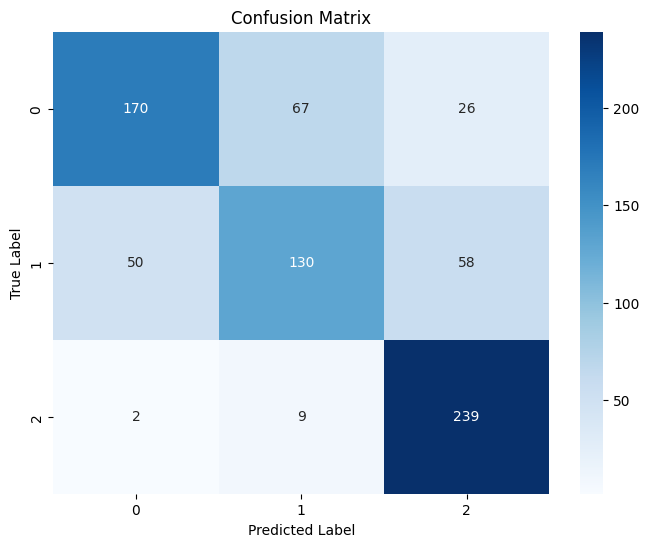

In [29]:
confusion_matrix(samples_=samples, predictions_=predictions)

## Iterar por más epochs

In [31]:
trainer.args.num_train_epochs = 20  # Para entrenar hasta la época 20
trainer.train(resume_from_checkpoint=_checkpoint)

/Users/julio/Documents/PMM/Codigos/Test1/Classification-ViT/.venv/lib/python3.11/site-packages/transformers/trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  to

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
11,0.330800,1.281284,0.641333,0.636022,0.642659,0.637959
12,0.246800,1.343381,0.669333,0.670267,0.669618,0.664401
13,0.199200,1.517215,0.677333,0.674994,0.678081,0.675772
14,0.139100,1.879345,0.688000,0.688703,0.688269,0.686119
15,0.062000,2.194973,0.682667,0.678038,0.683250,0.678490
16,0.039200,2.285322,0.662667,0.659342,0.664082,0.659915
17,0.028600,2.356433,0.670667,0.664693,0.671866,0.666547
18,0.025000,2.585787,0.676000,0.671392,0.676717,0.672178
19,0.021400,2.678839,0.668000,0.664226,0.668879,0.665863
20,0.015500,2.725527,0.672000,0.667791,0.672879,0.669517


TrainOutput(global_step=7520, training_loss=0.055415087930382564, metrics={'train_runtime': 4031.1213, 'train_samples_per_second': 29.783, 'train_steps_per_second': 1.865, 'total_flos': 3.288864877974981e+19, 'train_loss': 0.055415087930382564, 'epoch': 20.0})

In [32]:
trainer.save_model()

In [33]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.638569176197052,
 'eval_accuracy': 0.7177097203728362,
 'eval_precision': 0.7122572691420568,
 'eval_recall': 0.7162021066981925,
 'eval_f1': 0.7069408157010035,
 'eval_runtime': 35.2827,
 'eval_samples_per_second': 21.285,
 'eval_steps_per_second': 2.664,
 'epoch': 20.0}

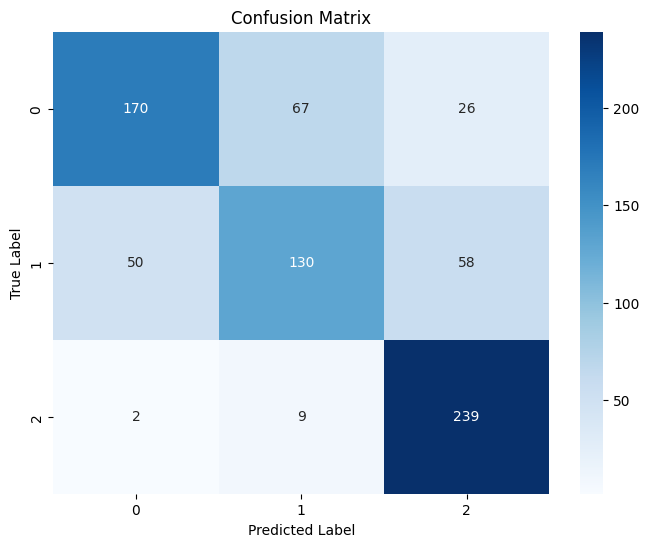

In [34]:
confusion_matrix(samples_=samples, predictions_=predictions)